<a href="https://colab.research.google.com/github/SzaboNikolettaLaura/GAAlgoritmusok/blob/main/Szabo_Nikoletta_LAB03_GA_Szelekcios_Modszerek_V1_Boltzman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Genetikus algoritmusok – **Szelekciós módszerek** (HU)

Ebben a jegyzetben a leggyakoribb szelekciós eljárásokat fogjuk gyakorolni:

- **Fitness arányos (rulettkerék)**
- **Tournament szelekció (k-fős verseny)**
- **Rang alapú szelekció**
- **Elitizmus**

Házi feladat extra pontokért:

- **Boltzmann / sztochasztikus szelekció** (Bónusz feladat)
- **Truncation (csonkolás)** (Bónusz feladat)


**Labor célja:** az evolúciós nyomás és diverzitás **egyensúlyának** bemutatása, valamint a módszerek **előnyeinek / hátrányainak** megértése.


In [3]:

import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
random.seed(7)
np.random.seed(7)



## 0) Oktatási minta-populáció

Az alábbi **kis populáció** segít szemléltetni a módszerek viselkedését. A fitness értékeket úgy választjuk, hogy legyenek **extrém különbségek** is (hogy lássuk a torzító hatást).

- Populáció méret: `N = 10`
- Fitness: néhány nagyon jó, több közepes, és 1–2 gyenge egyed


In [4]:

N = 10
ids = np.array([f"ind_{i}" for i in range(N)])

# Kézzel beállított, szemléltető fitnessek (extrém különbségekkel)
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

# Normalizáló segédfüggvények
def normalize_positive(x):
    # Eltolás, hogy minden érték >= 0 legyen
    m = np.min(x)
    if m < 0:
        x = x - m
    return x

def softmax_scaled(x, T=1.0):
    # Boltzmann valószínűségek: exp(x/T) normalizálva (numerikusan stabil)
    z = (x - np.max(x)) / max(T, 1e-8)
    e = np.exp(z)
    return e / np.sum(e)

print("Egyedek:", ids)
print("Fitness :", fitness)


Egyedek: ['ind_0' 'ind_1' 'ind_2' 'ind_3' 'ind_4' 'ind_5' 'ind_6' 'ind_7' 'ind_8'
 'ind_9']
Fitness : [ 2.   5.   1.  30.   4.   3.  18.   0.5  8.   0.2]


In [5]:

def plot_selection_counts(ids, counts, title):
    # Egyszerű oszlopdiagram: kiválasztási gyakoriságok
    plt.figure()
    x = np.arange(len(ids))
    plt.bar(x, counts)
    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(title)
    plt.tight_layout()
    plt.show()



## 1) Fitness arányos szelekció (rulettkerék)

**Ötlet:** az egyed kiválasztási valószínűsége arányos a fitness értékével.  
- **Előny:** egyszerű, intuitív.  
- **Hátrány:** **extrém** fitness különbségeknél **eltorzul**, a legjobb(ak) dominál(nak), **diverzitás csökkenhet**.

> Megjegyzés: negatív fitness esetén eltolást/normalizálást kell alkalmazni.


Rulettkerék valószínűségek (≈):
ind_0: p≈0.028
ind_1: p≈0.070
ind_2: p≈0.014
ind_3: p≈0.418
ind_4: p≈0.056
ind_5: p≈0.042
ind_6: p≈0.251
ind_7: p≈0.007
ind_8: p≈0.112
ind_9: p≈0.003


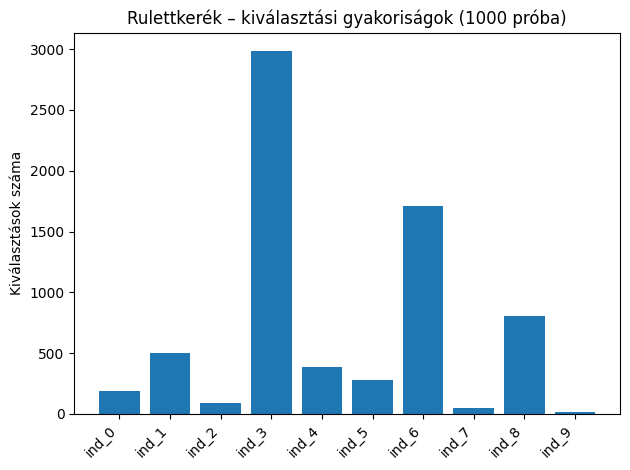

In [6]:

def roulette_wheel_selection(ids, fitness, n_select):
    f = normalize_positive(fitness.astype(float))
    total = np.sum(f)
    if total <= 0:
        # ha minden 0, uniform választás
        p = np.ones_like(f) / len(f)
    else:
        p = f / total
    # mintavétel visszatevéssel
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p

# Illusztráció: ismételt kiválasztások és gyakoriság diagram
n_trials = 7000
selected, probs = roulette_wheel_selection(ids, fitness, n_trials)
unique, counts = np.unique(selected, return_counts=True)

print("Rulettkerék valószínűségek (≈):")
for i, id_ in enumerate(ids):
    print(f"{id_}: p≈{probs[i]:.3f}")

# Grafikon
count_map = {u:c for u,c in zip(unique, counts)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])
plot_selection_counts(ids, counts_ordered, "Rulettkerék – kiválasztási gyakoriságok (1000 próba)")



## 2) Tournament szelekció (k-fős verseny)

**Ötlet:** minden kiválasztáshoz véletlenszerűen választunk `k` egyedet, és **közülük a legjobb** nyer.  
- **Előny:** **gyors**, **skálázható**, ritkábban zuhan túlzott szelekciós nyomásba.  
- **Paraméter:** a `k` növelése erősíti a szelekciós nyomást (kicsi `k` → több diverzitás).


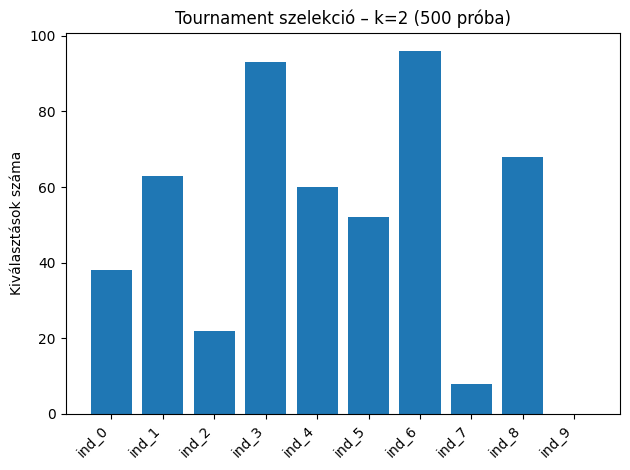

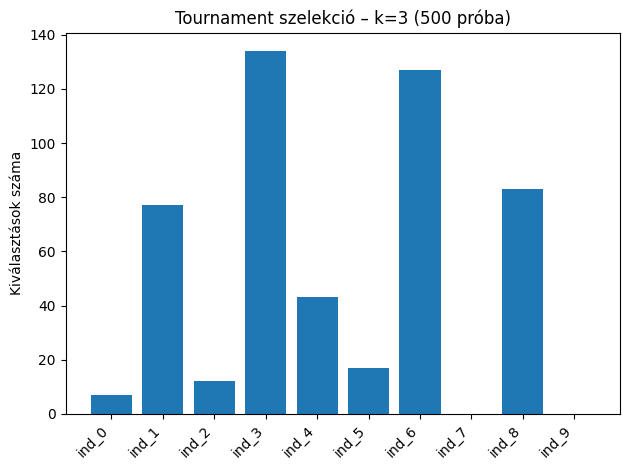

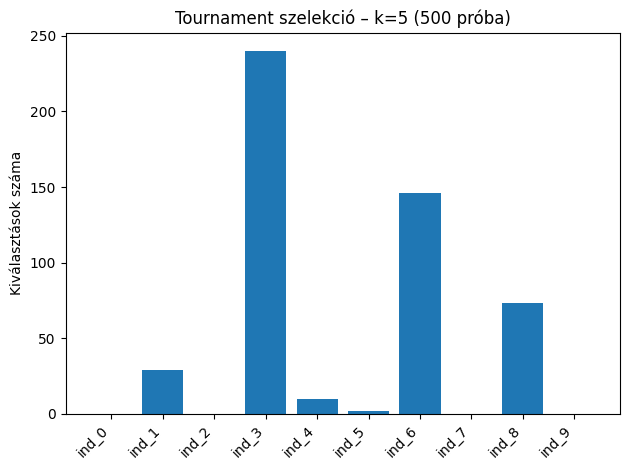

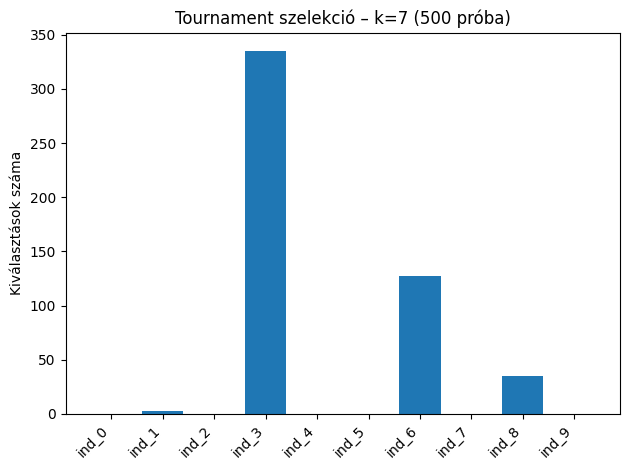

In [ ]:

def tournament_selection(ids, fitness, n_select, k=4):
    chosen = []
    for _ in range(n_select):
        idxs = np.random.choice(len(ids), size=k, replace=False)
        best_idx = idxs[np.argmax(fitness[idxs])]
        chosen.append(ids[best_idx])
    return np.array(chosen)

# Hasonlítsuk össze különböző k értékekkel
for k in [2, 3, 5, 7]:
    n_trials = 500
    sel = tournament_selection(ids, fitness, n_trials, k=k)
    uniq, cnt = np.unique(sel, return_counts=True)
    count_map = {u:c for u,c in zip(uniq, cnt)}
    counts_ordered = np.array([count_map.get(i, 0) for i in ids])
    plot_selection_counts(ids, counts_ordered, f"Tournament szelekció – k={k} (500 próba)")



## 3) Rang alapú szelekció

**Ötlet:** az egyedeket **rangsoroljuk** fitness szerint, és a kiválasztási esély a **ranghoz kötött**.  
- **Előny:** stabilizálja a szelekciót, **ellenálló** extrém fitness különbségeknél is (nem engedi túl-dominálni a csúcs értékeket).  
- **Megvalósítás:** pl. lineáris rangsúlyozás – a legjobb rang kapja a legnagyobb valószínűséget, de arányok kontrolláltak.


Rangsúlyok (legnagyobb a legjobb): [ 4  7  3 10  6  5  9  2  8  1]
Rang alapú valószínűségek (≈): [0.073 0.127 0.055 0.182 0.109 0.091 0.164 0.036 0.145 0.018]


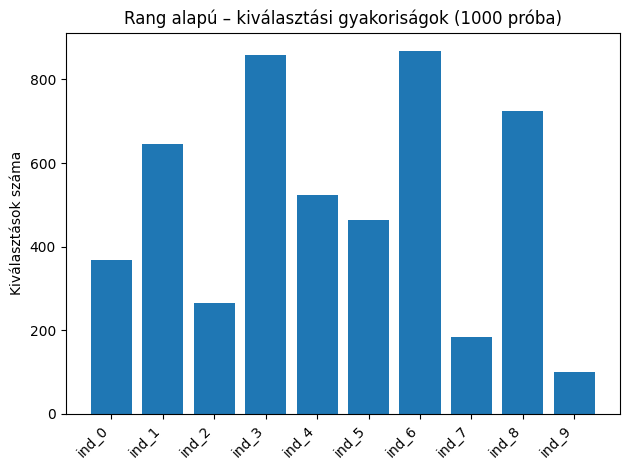

In [ ]:

def rank_based_selection(ids, fitness, n_select):
    # Rangsorolás (nagyobb fitness -> jobb rang)
    order = np.argsort(-fitness)  # desc
    ranks = np.empty_like(order)
    ranks[order] = np.arange(len(ids), 0, -1)  # legjobb kapja a legnagyobb rangszámot

    # Lineáris valószínűség a ranghoz arányosan
    p = ranks / np.sum(ranks)
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p, ranks

n_trials = 5000
selected, p_rank, ranks = rank_based_selection(ids, fitness, n_trials)
uniq, cnt = np.unique(selected, return_counts=True)
count_map = {u:c for u,c in zip(uniq, cnt)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])

print("Rangsúlyok (legnagyobb a legjobb):", ranks)
print("Rang alapú valószínűségek (≈):", np.round(p_rank, 3))
plot_selection_counts(ids, counts_ordered, "Rang alapú – kiválasztási gyakoriságok (1000 próba)")



## 4) Elitizmus

**Ötlet:** a **legjobb** `E` egyed **garantáltan** átkerül a következő generációba.  
- **Előny:** a **legjobb megoldás** nem vész el.  
- **Hátrány:** túl erős elitizmus → **diverzitás csökken**, **lokális optimumhoz ragadhat**.

Az alábbi példa egyetlen generációt illusztrál: először elit másolás, majd a maradék helyek feltöltése (pl. rang alapú szelekcióval).


In [21]:

def elite_preservation(ids, fitness, E=2):
    # top-E indexek
    order = np.argsort(-fitness)
    elites = ids[order[:E]]
    return elites

def next_generation_with_elite(ids, fitness, pop_size=10, E=3):
    elites = elite_preservation(ids, fitness, E=E)
    remaining = pop_size - E
    selected, _, _ = rank_based_selection(ids, fitness, remaining)
    # új generáció (azonosítók szintjén bemutatva)
    new_gen = np.concatenate([elites, selected])
    return new_gen

new_gen = next_generation_with_elite(ids, fitness, pop_size=10, E=2)
print("Elitek:", elite_preservation(ids, fitness, E=2))
print("Új generáció (azonosítók):", new_gen)


Elitek: ['ind_3' 'ind_6']
Új generáció (azonosítók): ['ind_3' 'ind_6' 'ind_8' 'ind_5' 'ind_8' 'ind_4' 'ind_0' 'ind_1' 'ind_8'
 'ind_8']



## 5) Boltzmann / sztochasztikus szelekció

**Ötlet:** valószínűségek **hőmérsékletfüggők** – `p_i ∝ exp(fitness_i / T)`  
- **Magas T:** közel **egyenletes** kiválasztás → **nagy diverzitás**.  
- **Alacsony T:** a nagy fitness **dominál** → **erős nyomás**.

Gyakori stratégia: **hűtés** (T fokozatos csökkentése).



## 6) Truncation (csonkolás) szelekció

**Ötlet:** csak a **legjobb** `p%` kerülhet tovább, a többiek kiesnek.  
- **Előny:** **nagyon erős** szelekciós nyomás, gyors konvergencia.  
- **Hátrány:** **diverzitás** gyors elvesztése, könnyebb **lokális optimum**.

Az alábbi implementáció a top `p%` halmazból választ **visszatevéssel** (ha a populációt ugyanarra a méretre akarjuk feltölteni).



## 7) Kérdések és rövid, gyakorlati válaszok

**Mi a különbség a rulettkerék- és a tournament-szelekció között?**  
- Rulettkerék: valószínűség **arányos** a fitness-szel → **extrém értékek torzíthatnak**.  
- Tournament: mindig **k** jelölt versenyez, a **legjobb nyer** → paraméterezhető nyomás, **skálázható** és robusztusabb extrémekkel szemben.

**Miért előnyös a rang alapú szelekció extrém fitness különbségek esetén?**  
- Mert a kiválasztási esélyt **nem a nyers fitness**, hanem a **rang** határozza meg → **stabilabb**, nem engedi a túl-dominanciát.

**Milyen előnye és hátránya van az elitizmusnak?**  
- Előny: a **legjobb megoldás** nem vész el, **monoton** javulás biztosítható.  
- Hátrány: túl nagy elit arány → **diverzitás** csökken, **beszorulás** lokális optimumba.

**Mely szelekciós módszer illik legjobban a permutációs ábrázoláshoz?**  
- Gyakorlati tapasztalat szerint a **tournament** és **rang alapú** jól működik permutációknál, mert **robosztusabbak** az outlierekkel szemben és jól **skálázódnak**.

**Miért engednek néha a gyengébb egyedeknek is esélyt a szelekcióban?**  
- A **diverzitás** fenntartása miatt: a túl erős nyomás **korai konvergenciához** vezethet. Némi véletlen esély segít elkerülni a **lokális optimumot** és támogatja a **feltárást**.


# Szelekciós módszerekhez gyakorló feladatok
Ez a notebook a szelekciós módszerekhez és deceptív függvényekhez kapcsolódó gyakorlófeladatokat tartalmazza.

## 1. Feladat – Rulettkerék valószínűségek
Számold ki a rulettkerekes kiválasztási valószínűségeket.
Az ids és fitness tömbök alapján:



1.   Számold ki a fitness-ek összegét.
2.   Számold ki minden egyed rulettkerekes kiválasztási valószínűségét:

$$
p_i = \frac{f_i}{\sum_j f_j}
$$


2.   Add meg, melyik egyedé a legnagyobb és a legkisebb valószínűség.

Megjegyzés: elég 3-4 tizedesig kerekíteni.

In [9]:
fit_sum = sum(fitness)
if fit_sum == 0:
  p = [1/N for i in range(N)]
else:
  p = [fit / fit_sum for fit in fitness]
print(p)
legnagyobb = max(p)
legkisebb = min(p)
print('legnagyobb', legnagyobb)
print('legkisebb', legkisebb)

[np.float64(0.02789400278940028), np.float64(0.0697350069735007), np.float64(0.01394700139470014), np.float64(0.41841004184100417), np.float64(0.05578800557880056), np.float64(0.04184100418410042), np.float64(0.2510460251046025), np.float64(0.00697350069735007), np.float64(0.11157601115760112), np.float64(0.002789400278940028)]
legnagyobb 0.41841004184100417
legkisebb 0.002789400278940028


## 2. Feladat – Tournament szelekció (k=3)
Véletlenszerűen válassz 3 különböző egyedet, indexet 0 és 9 között (pl. 2, 4, 6) a populációból.

1.   Írd fel, mely egyedek kerültek a tournament-be (ind_2, ind_4, ind_6) és mi a fitness-ük.
2.   Döntsd el, ki nyer a tournament-ben (ki kerül kiválasztásra).
3.   Röviden írd le: miért mondjuk, hogy a tournament szelekció „erősebb szelekciós nyomást” tud adni, mint a rulettkerék?

In [11]:
import numpy as np
import random

part = np.random.choice(N, p=fitness/sum(fitness), size=3, replace=False)

tids = ids[part]
tfits = fitness[part]

print("tournament resztvevok:", tids)
print("resztvevok fitnessei:", tfits)

gyoztes = np.argmax(tfits)
print("nyertes:", tids[gyoztes], "fitness:", tfits[gyoztes])

# a tournament szelekcio altal van eselye barmelyik egyednek reszt venni, tehat lehet gyoztes, kiveve a leggyengebb parat

tournament resztvevok: ['ind_3' 'ind_6' 'ind_2']
resztvevok fitnessei: [30. 18.  1.]
nyertes: ind_3 fitness: 30.0


## 3. Feladat – Rang alapú szelekció
Rangsorolás és vizsgálat.


1.   Rendezd a populációt fitnesz szerint csökkenő sorrendbe.
2.   Adj mindenkinek rangot (1 = legjobb, 10 = legrosszabb).
3.   Írd fel a (id, fitness, rang) hármast egy kis táblázatba.
4.   Magyarázd meg 2 mondatban, miért kevésbé érzékeny a rang alapú szelekció az extrém fitness értékekre, mint a rulettkerék.

In [13]:
import numpy as np
import random

rendezett = np.argsort(fitness)[::-1]

for rank, idx in enumerate(rendezett, start=1):
    id = ids[idx]
    fit = fitness[idx]

    print(rank, '.', id, fit)


# a rang alapu szelekcioban csak a sorrend szamit, nem az eredeti fitness ertek, tehat lesz eselye mindenkinek, csak egyre kevesebb

1 . ind_3 30.0
2 . ind_6 18.0
3 . ind_8 8.0
4 . ind_1 5.0
5 . ind_4 4.0
6 . ind_5 3.0
7 . ind_0 2.0
8 . ind_2 1.0
9 . ind_7 0.5
10 . ind_9 0.2


## 4. Feladat (közepes) – Rulettkerék vs Tournament (10 000 futás)
Hasonlítsd össze a gyakoriságokat. Írj egy rövid Python-kódot, amely:

1.   A notebook-ban korábban definiált ids, fitness tömböt használd.
2.   10 000-szer kiválasztunk:
  - (a) rulettkerékkel,
  - (b) 3-fős tournament-tel.
3.   Külön-külön számold ki, hogy hányszor lett kiválasztva minden egyed.
4.   Ábrázold oszlopdiagramon:
 - x tengely: ind_0 … ind_9
 - y tengely: kiválasztási gyakoriság.
5.   Írj 4–5 mondatot arról, miben különbözik a két eloszlás (melyiknél koncentrálódik jobban a tömeg a legjobb egyedekre, mennyire marad „esélye” a gyengébbeknek stb.).


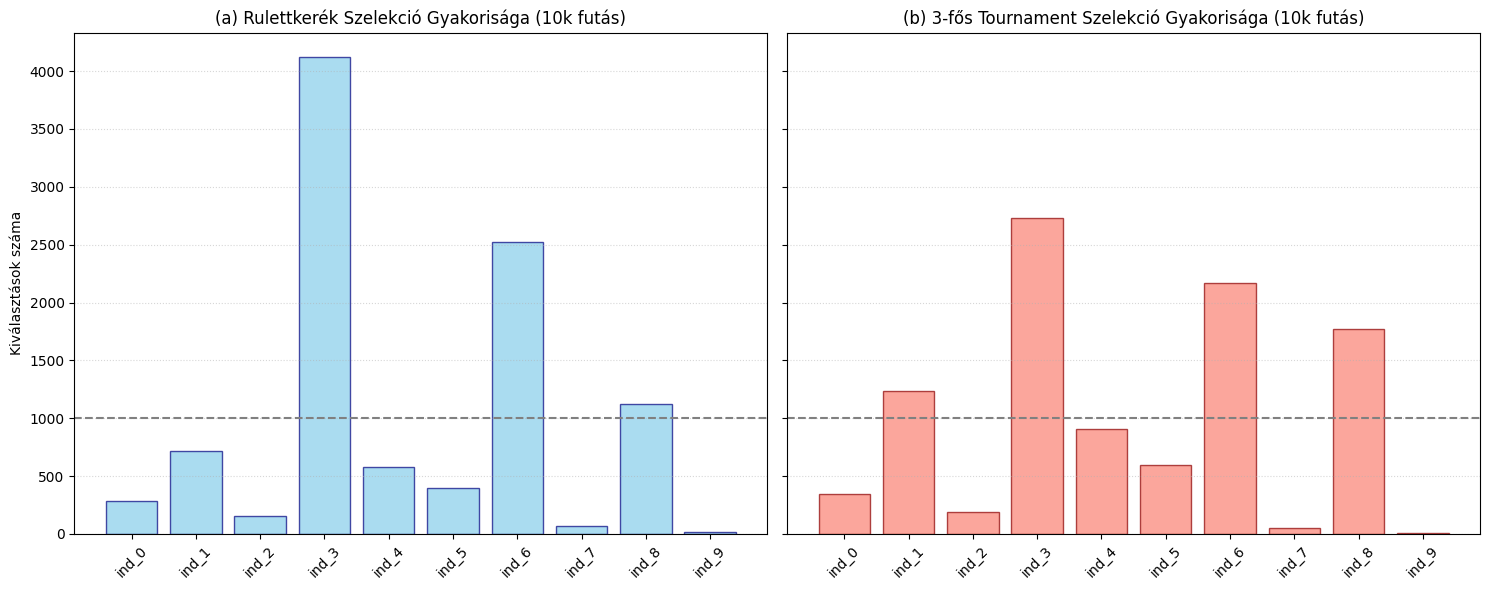

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random

N = len(ids)

total_fitness = np.sum(fitness)
if total_fitness == 0:
    p = np.ones(N) / N
else:
    p = fitness / total_fitness

rulett_gyoztes = np.random.choice(N, size=10000, p=p, replace=True)

rulett_hanyszor = np.bincount(rulett_gyoztes, minlength=N)


c = np.zeros(N, dtype=int)
K = 3

for _ in range(10000):
    idx = np.random.choice(N, size=K, replace=True)
    fits = fitness[idx]
    wlocal = np.argmax(fits)
    c[idx[wlocal]] += 1

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

expected_avg = 10000 / N

axes[0].bar(ids, rulett_hanyszor, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlagos gyakoriság')
axes[0].set_title("(a) Rulettkerék Szelekció Gyakorisága (10k futás)", fontsize=12)
axes[0].set_ylabel("Kiválasztások száma", fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle=':', alpha=0.5)

axes[1].bar(ids, c, color='salmon', edgecolor='darkred', alpha=0.7)
axes[1].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlagos gyakoriság')
axes[1].set_title(f"(b) {K}-fős Tournament Szelekció Gyakorisága (10k futás)", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# a rulettkerek szelekcio eseten nagyobb gyakorisaggal valasztodnak ki az "eros" egyedek, es megtortenhet hogy egyes gyenge egyedek soha
# a tournament szelekcio kicsit enyhiti ezt, a leggyengebb soha nem valasztodik ki, de a tobbiek kozott kicsit eloszlik a gyakorisag

## 5. Feladat (közepes) – Rang alapú szelekció paraméterérzékenysége

Egészítsd ki a laborkódot úgy, hogy:
1.   Legyen egy függvényed rank_based_selection(ids, fitness, N, s), ahol
- s = szelekciós nyomás (pl. 1.0–2.0 között),
- kiválasztási valószínűségek a rang alapján (pl. Baker-féle lineáris rangszelekció).
2.   Végezz kísérletet 10 000 kiválasztással:
- (a) s = 1.1
- (b) s = 1.9
3.   Hasonlítsd össze a kiválasztási gyakoriságokat: melyik s esetén erősebb a szelekciós nyomás?
4.   Fogalmazz meg 3 következtetést (pl. „nagy s esetén a gyenge egyedek szinte eltűnnek” stb.).

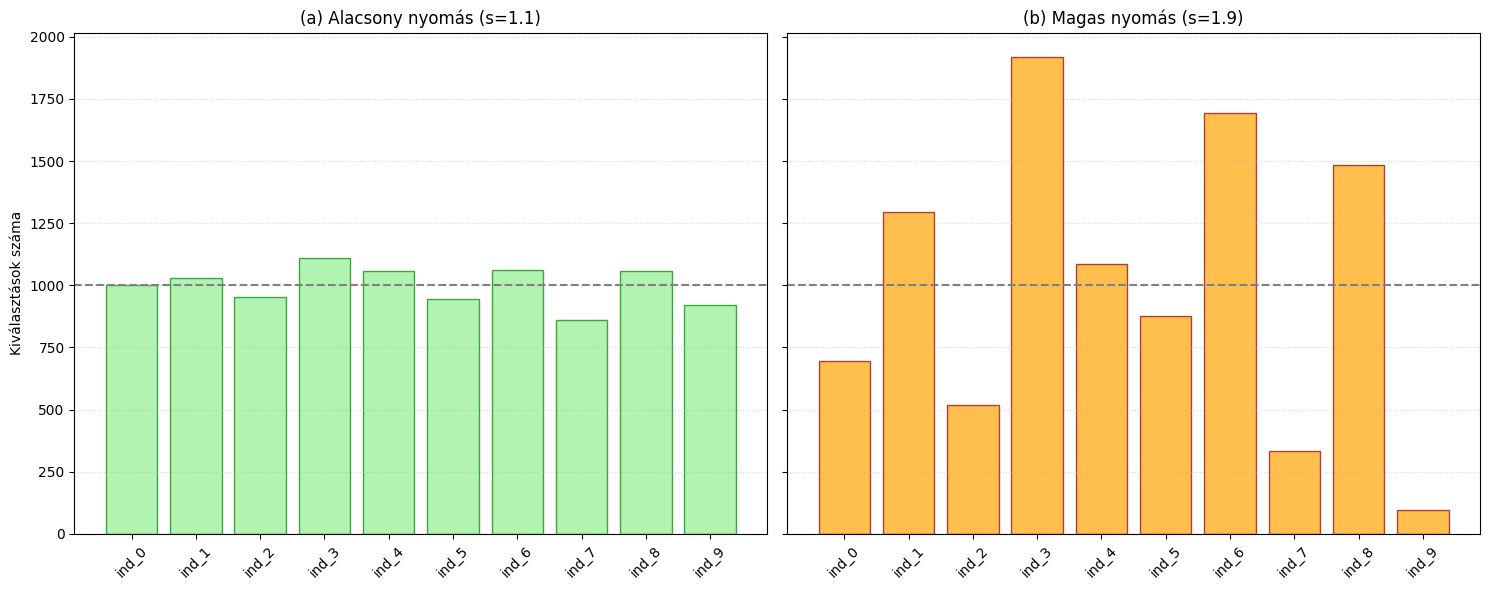

In [17]:
# rank_based_selection implementáció

def rank_based_selection(m, s):
    sorted_indices = np.argsort(fitness)[::-1]

    ranks = np.arange(N)
    p = (1/N) * (s - (2 * (s - 1) * ranks / (N - 1)))

    p /= p.sum()

    idx = np.random.choice(N, size=m, p=p)
    ids = sorted_indices[idx]
    counts = np.bincount(ids, minlength=N)

    return counts

counts_low_s = rank_based_selection(10000, s=1.1)

counts_high_s = rank_based_selection(10000, s=1.9)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
expected_avg = 10000 / len(ids)

axes[0].bar(ids, counts_low_s, color='lightgreen', edgecolor='green', alpha=0.7)
axes[0].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlag')
axes[0].set_title(f"(a) Alacsony nyomás (s=1.1)", fontsize=12)
axes[0].set_ylabel("Kiválasztások száma")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle=':', alpha=0.5)

axes[1].bar(ids, counts_high_s, color='orange', edgecolor='darkred', alpha=0.7)
axes[1].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlag')
axes[1].set_title(f"(b) Magas nyomás (s=1.9)", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

# az alacsony nyomas hatasara a kulonbsegek is kicsikke valnak, mindenki kap eselyt, csak valamennyivel tobbet a nagy fitness ertekuek
# a nagy nyomas meg noveli az esely kulonbseget
# az s parameter fuggvenyeben intenzifikalodnak a kulonbsegek

## 6. Feladat (közepes) – Elitizmus hatása a diverzitásra
Használd a jegyzetben lévő next_generation_with_elite ötletét:
1.   Készíts egy szimulációt, ahol:
- Populációméret = 10
- Elit méret E = 0, E = 2, E = 5
- Új generáció többi részét mondjuk rang alapú szelekcióval töltöd fel.
2.   Egy egyszerű GA-keretben (pl. 20 generáció, csak szelekció + „dummy” fitness frissítés nélkül) nézd meg:
- Hány különböző egyed marad a populációban (diverzitás) az idő előrehaladtával?
3.   Írj 5–6 mondatot arról, hogyan hat az elitizmus mértéke a diverzitásra és a „beszorulás” kockázatára.

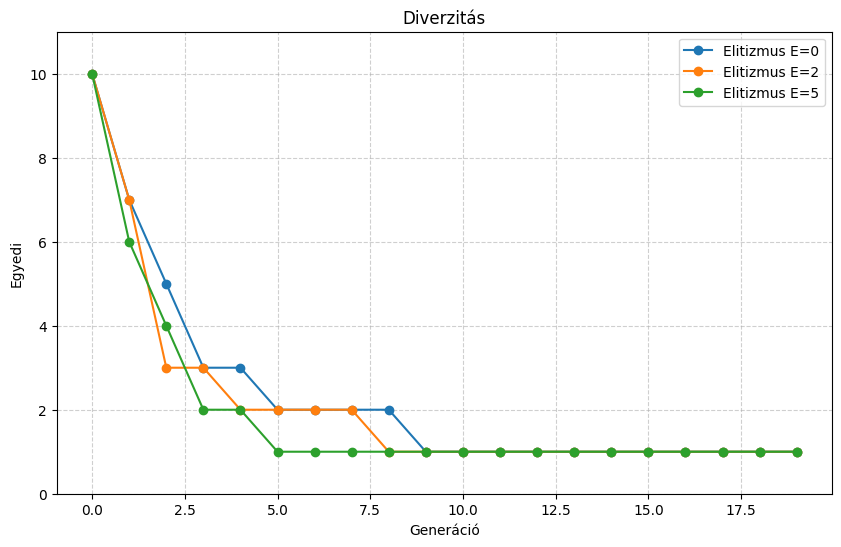

In [23]:
# Diverzitás mérése és grafikon
import numpy as np
import matplotlib.pyplot as plt
import random

generations = 20
elitism_levels = [0, 2, 5]
results = {}

def rank_based_selection(ids, fitness, m):
    order = np.argsort(-fitness)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(len(ids), 0, -1)

    p = ranks / np.sum(ranks)
    chosen = np.random.choice(ids, size=m, replace=True, p=p)
    return chosen, p, ranks

egyedek = dict(zip(ids, fitness))
for E in elitism_levels:
    current_pop = ids.copy()
    h = []

    for _ in range(generations):
        current_fitness = np.array([egyedek[uid] for uid in current_pop])
        h.append(len(np.unique(current_pop)))
        current_pop = next_generation_with_elite(current_pop, current_fitness, pop_size=N, E=E)

    results[E] = h


plt.figure(figsize=(10, 6))
for E, history in results.items():
    plt.plot(history, marker='o', label=f'Elitizmus E={E}')

plt.title("Diverzitás")
plt.xlabel("Generáció")
plt.ylabel("Egyedi")
plt.ylim(0, 11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# magas elitizmus segithet az optimalis megoldas gyorsabb megtalalasaban, viszont azzal a veszellyel jar, hogy az a gen allomany ami ahhoz vezetett volna, hamarabb kihal

## 7. Feladat (nehéz) – Boltzmann-szelekció és hőmérséklet ütemezés
Készíts egy saját Boltzmann-szelekció modult, a jegyzetben lévő softmax_scaled függvényt felhasználva:

1.   Definiálj hőmérséklet-idő függvényt:
- (a) Lassú hűtés: T(t) = 5 / (1 + 0.05 * t)
- (b) Gyors hűtés: T(t) = 5 / (1 + 0.5 * t),
- ahol t a generáció sorszáma (0…50).
2.   Egy egyszerű GA-keretben, fix fitness-szel (a laborminta-populáció), 50 generáción át:
- minden generációban számold ki a Boltzmann-alapú kiválasztási valószínűségeket az aktuális T(t) mellett,
- végezz 10 kiválasztást (új populáció).
3.   Mérd minden generációnál:
- a legjobb egyed várható fitnessét (pl. populációmax),
- és a diverzitást (különböző egyedek száma, vagy Shannon-entrópia a gyakoriságokból).
4.   Hasonlítsd össze a lassú és gyors hűtést:
- Melyik esetben „hűl be” gyorsabban a rendszer (csökken a diverzitás)?
- Melyik esetben jobb a végső (50. generációs) legjobb fitness?
5.   Fogalmazz meg rövid szakmai következtetést: mikor lehet hasznos a Boltzmann-szelekció, és hogyan kell óvatosan megválasztani a hőmérséklet ütemezést?

## Softmax / Boltzmann-szelekció

A szelekciós valószínűség képlete blokkos formában:

$$
p_i = \frac{\exp\left(\frac{f_i}{T}\right)}{\sum_{j} \exp\left(\frac{f_j}{T}\right)}
$$

A hőmérséklet időbeli csökkenésének (annealing) tipikus ütemezései:

### Inverz hűtés:
$$
T(t) = \frac{T_0}{1 + \alpha t}
$$

### Exponenciális hűtés:
$$
T(t) = T_0 \cdot \beta^{t}
$$


Kis segítség ....
```
function boltzmann_selection(fitness, T):
    for each f_i in fitness:
        w_i = exp(f_i / T)
    total = sum(w_i)
    p_i = w_i / total
    return p_i

```


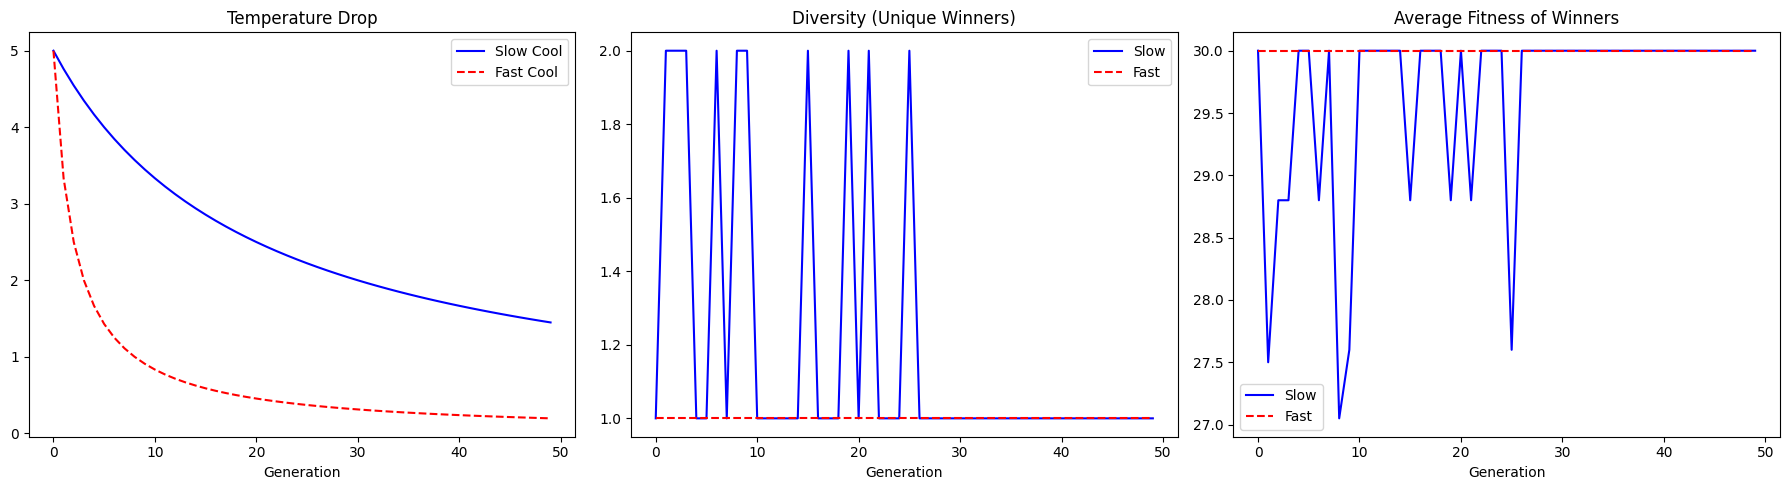

In [24]:
import math
import random
import matplotlib.pyplot as plt

def boltzmann_selection(scores, temperature):
    if temperature < 0.00001:
        temperature = 0.00001

    max_score = max(scores)

    weights = []
    for score in scores:
        val = math.exp((score - max_score) / temperature)
        weights.append(val)

    total_weight = sum(weights)
    probabilities = []
    for w in weights:
        probabilities.append(w / total_weight)

    return probabilities

def get_temperature(time, mode):
    if mode == 'slow':
        return 5 / (1 + 0.05 * time)
    elif mode == 'fast':
        return 5 / (1 + 0.5 * time)
    return 5.0

generations = 50
modes = ['slow', 'fast']
results = {}

for mode in modes:
    diversity_log = []
    avg_fitness_log = []
    temp_log = []

    random.seed(42)

    for t in range(generations):
        temp = get_temperature(t, mode)
        temp_log.append(temp)

        probs = boltzmann_selection(fitness, temp)

        population_indices = list(range(N))

        selected_indices = random.choices(population_indices, weights=probs, k=10)

        unique_winners = set(selected_indices)
        diversity = len(unique_winners)
        diversity_log.append(diversity)

        sum_fit = 0
        for idx in selected_indices:
            sum_fit += fitness[idx]
        avg_fit = sum_fit / len(selected_indices)
        avg_fitness_log.append(avg_fit)

    results[mode] = {
        'diversity': diversity_log,
        'fitness': avg_fitness_log,
        'temp': temp_log
    }

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(results['slow']['temp'], color='blue', label='Slow Cool')
axes[0].plot(results['fast']['temp'], color='red', linestyle='--', label='Fast Cool')
axes[0].set_title("Temperature Drop")
axes[0].set_xlabel("Generation")
axes[0].legend()

axes[1].plot(results['slow']['diversity'], color='blue', label='Slow')
axes[1].plot(results['fast']['diversity'], color='red', linestyle='--', label='Fast')
axes[1].set_title("Diversity (Unique Winners)")
axes[1].set_xlabel("Generation")
axes[1].legend()

axes[2].plot(results['slow']['fitness'], color='blue', label='Slow')
axes[2].plot(results['fast']['fitness'], color='red', linestyle='--', label='Fast')
axes[2].set_title("Average Fitness of Winners")
axes[2].set_xlabel("Generation")
axes[2].legend()

plt.tight_layout()
plt.show()

# elemzes a fenti eredmenyekrol

# a gyors hutesnel (piros vonal) nagyon hamar meghal a diverzitas
# kb 10 generacio utan mar csak a legerosebbek maradnak es nincs ujitas
# ez azert baj mert ha rossz helyen vagyunk akkor ott ragadunk

# a lassu hutesnel (kek vonal) meg sokaig van eselye a gyengebbeknek is
# ezert latod hogy a grafikon ugral kicsit mert meg probalgatja a lehetosegeket

# mire jo a boltzmann
# az a cel hogy az elejen legyen nagy a kaosz (magas homerseklet) es mindent kiprobaljunk
# a vegen viszont legyen rend (alacsony homerseklet) hogy a legjobbat tartsuk meg

# a tanulsag
# ha tul gyorsan hutesz akkor elveszik a sokszinuseg mielott megtalalnad az igazi legjobb megoldast
# ilyenkor az algoritmus elakad egy helyi csucson es nem talalja meg a globalisat
# lenyegeben ha tul gyorsan hutesz akkor feleslegesen dolgoztal mert olyan mintha siman mindig a legjobbat valasztanad